In [1]:
# Common 
import os
import keras
import numpy as np 
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
# Data
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization 
import plotly.express as px
import matplotlib.pyplot as plt

# Models
from keras import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet101V2

In [2]:
info_file = './monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv'
info = pd.read_csv(info_file)
info.head()

,ImageID,Label
0,M01_01,Monkeypox
1,M01_02,Monkeypox
2,M01_03,Monkeypox
3,M01_04,Monkeypox
4,M02_01,Monkeypox


In [3]:
fig = px.pie(
    names=info.Label.unique(),
    values=info.Label.value_counts(),
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title':{'text':'Class Distribution','x':0.45}})
fig.show()

In [4]:
# Data Generators
train_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
# valid_gen = ImageDataGenerator(rescale=1./255)

# Loading Data
train_data = train_gen.flow_from_directory("./monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images",target_size=(256,256),shuffle=True,class_mode='binary')
valid_data = train_gen.flow_from_directory('./monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')
# test_data = valid_gen.flow_from_directory('./monkeypox-skin-lesion-dataset/Original Images/Original Images',target_size=(256,256),shuffle=True,subset='validation',class_mode='binary')

Found 3192 images belonging to 2 classes.
Found 637 images belonging to 2 classes.


In [5]:
# Get all batches of training data
train_batches = train_data.__iter__()
trainx, trainy = [], []
for i in range(len(train_data)):
    X, y = next(train_batches)
    trainx.append(X)
    trainy.append(y)

# Concatenate all batches into one array
trainx = np.concatenate(trainx)
trainy = np.concatenate(trainy)

# Get all batches of test data
test_batches = valid_data.__iter__()
testx, testy = [], []
for i in range(len(valid_data)):
    X, y = next(test_batches)
    testx.append(X)
    testy.append(y)

# Concatenate all batches into one array
testx = np.concatenate(testx)
testy = np.concatenate(testy)

# # Get all batches of valid data
# valid_batches = test_data.__iter__()
# validx, validy = [], []
# for i in range(len(test_data)):
#     X, y = next(valid_batches)
#     validx.append(X)
#     validy.append(y)

# # Concatenate all batches into one array
# validx = np.concatenate(validx)
# validy = np.concatenate(validy)


In [6]:
print(testx.shape)
print(testy.shape)
print(trainx.shape)
print(trainy.shape)
# print(validx.shape)
# print(validy.shape)

(637, 256, 256, 3)
(637,)
(3192, 256, 256, 3)
(3192,)


In [7]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input
# from tensorflow.keras.models import Model

# def resnet_block(input_tensor, filters, strides):
#     x = Conv2D(filters, 3, strides=strides, padding='same')(input_tensor)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, 3, padding='same')(x)
#     x = BatchNormalization()(x)
#     residual = Conv2D(filters, 1, strides=strides, padding='same')(input_tensor)
#     x = Add()([x, residual])
#     x = Activation('relu')(x)
#     return x

# def ResNet101V2(input_shape=(256, 256, 3), num_classes=1):
#     inputs = Input(shape=input_shape)
#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = resnet_block(x, 64, 1)
#     for i in range(3):
#         x = resnet_block(x, 128, 2)
#     for i in range(4):
#         x = resnet_block(x, 256, 2)
#     for i in range(23):
#         x = resnet_block(x, 512, 2)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dense(164, activation='relu')(x)
#     x = BatchNormalization()(x)
#     outputs = Dense(num_classes, activation='sigmoid')(x)
#     model = Model(inputs, outputs)
#     return model

# with tf.device('/GPU:0'):
#     model = ResNet101V2(input_shape=(256,256,3))
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer='Adam',
#         metrics=['accuracy']
#     )
#     cb = [EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True),
#           ModelCheckpoint("ResNet101V2-01.h5",save_best_only=True)]

#     model.fit(
#         train_data,
#         epochs=50,
#         validation_data=valid_data,
#         callbacks=cb
#     )


In [8]:

with tf.device('/GPU:0'):
  base_model = ResNet101V2(
      include_top=False,
      input_shape=(256,256,3)
  )
  base_model.trainable = False

  model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(256,activation='relu'),
      BatchNormalization(),
      Dense(164,activation='relu'),
      BatchNormalization(),
      Dense(1,activation='sigmoid')
  ])

  model.compile(
      loss='binary_crossentropy',
      optimizer='Adam',
      metrics=['accuracy']
  )

cb = [EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet101V2-01.h5",save_best_only=True)]

model.fit(
    train_data,
    epochs=50,
    validation_data=valid_data,
    callbacks=cb
)


Epoch 1/50
100/100 [==============================] - 39s 299ms/step - loss: 0.2471 - accuracy: 0.8944 - val_loss: 0.0734 - val_accuracy: 0.9827
Epoch 2/50
100/100 [==============================] - 26s 259ms/step - loss: 0.0749 - accuracy: 0.9759 - val_loss: 0.0433 - val_accuracy: 0.9890
Epoch 3/50
100/100 [==============================] - 26s 255ms/step - loss: 0.0646 - accuracy: 0.9784 - val_loss: 0.0293 - val_accuracy: 0.9890
Epoch 4/50
100/100 [==============================] - 26s 259ms/step - loss: 0.0607 - accuracy: 0.9781 - val_loss: 0.0245 - val_accuracy: 0.9953
Epoch 5/50
100/100 [==============================] - 27s 263ms/step - loss: 0.0337 - accuracy: 0.9903 - val_loss: 0.0159 - val_accuracy: 0.9953
Epoch 6/50
100/100 [==============================] - 26s 260ms/step - loss: 0.0365 - accuracy: 0.9881 - val_loss: 0.0126 - val_accuracy: 0.9969
Epoch 7/50
100/100 [==============================] - 26s 261ms/step - loss: 0.0402 - accuracy: 0.9862 - val_loss: 0.0073 - val_ac

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 164)               42148     
                                                                 
 batch_normalization_1 (Batc  (None, 164)              6

In [10]:
from sklearn.model_selection import KFold
import numpy as np
import os


k = 4
kfold = KFold(k, shuffle=True, random_state=42)
scores = []
for train, test in kfold.split(trainx):
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    model.fit(
            train_data,
            epochs=50,
            validation_data=valid_data,
            
        )
    scores.append(model.evaluate(valid_data, verbose=0))

print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))


Epoch 1/50
100/100 [==============================] - 31s 249ms/step - loss: 0.0448 - accuracy: 0.9853 - val_loss: 0.0249 - val_accuracy: 0.9906
Epoch 2/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0342 - accuracy: 0.9865 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0362 - accuracy: 0.9865 - val_loss: 0.0101 - val_accuracy: 0.9937
Epoch 4/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0189 - accuracy: 0.9925 - val_loss: 0.0140 - val_accuracy: 0.9953
Epoch 5/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0257 - accuracy: 0.9900 - val_loss: 0.0128 - val_accuracy: 0.9953
Epoch 6/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0241 - accuracy: 0.9915 - val_loss: 0.0135 - val_accuracy: 0.9937
Epoch 7/50
100/100 [==============================] - 23s 231ms/step - loss: 0.0341 - accuracy: 0.9862 - val_loss: 0.0087 - val_ac

20/20 [==============================] - 5s 194ms/step


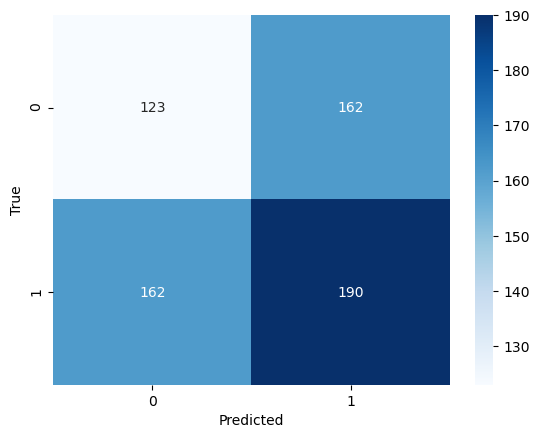

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the classes of validation data using the trained model

valid_pred = np.round(model.predict(valid_data))
valid_pred = np.squeeze(valid_pred)
valid_pred = valid_pred.astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(testy, valid_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/50
100/100 [==============================] - 23s 230ms/step - loss: 0.0023 - accuracy: 0.9991 - val_loss: 6.1116e-05 - val_accuracy: 1.0000
Epoch 2/50
100/100 [==============================] - 23s 229ms/step - loss: 0.0018 - accuracy: 0.9991 - val_loss: 4.0543e-05 - val_accuracy: 1.0000
Epoch 3/50
100/100 [==============================] - 23s 229ms/step - loss: 3.4076e-04 - accuracy: 1.0000 - val_loss: 6.6025e-05 - val_accuracy: 1.0000
Epoch 4/50
100/100 [==============================] - 23s 229ms/step - loss: 3.0582e-04 - accuracy: 1.0000 - val_loss: 6.3149e-06 - val_accuracy: 1.0000
Epoch 5/50
100/100 [==============================] - 23s 229ms/step - loss: 3.7540e-04 - accuracy: 1.0000 - val_loss: 1.4188e-05 - val_accuracy: 1.0000
Epoch 6/50
100/100 [==============================] - 23s 229ms/step - loss: 6.7344e-04 - accuracy: 1.0000 - val_loss: 5.8427e-06 - val_accuracy: 1.0000
Epoch 7/50
100/100 [==============================] - 23s 229ms/step - loss: 0.0030 - accu

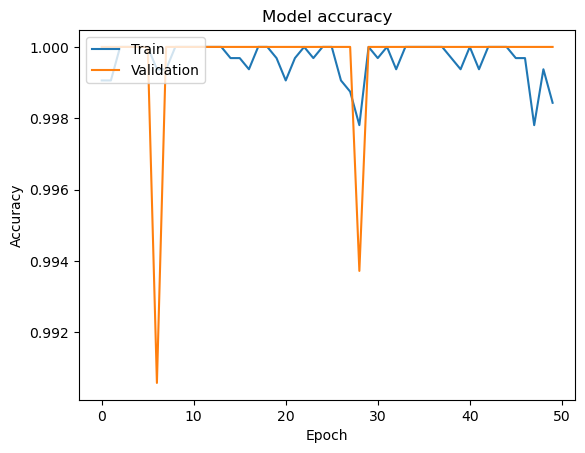

In [12]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=valid_data,
    
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

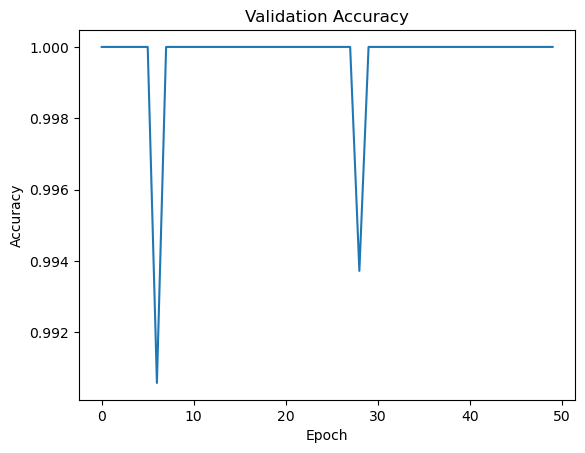

In [13]:

history = model.history
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

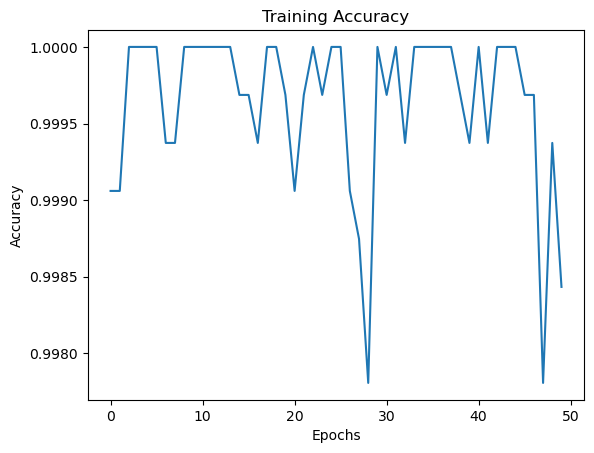

In [14]:
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [15]:
from sklearn.metrics import classification_report
# Predict the class probabilities for the validation data
predictions = model.predict(valid_data)

# Convert the predictions to class labels
predictions_classes = np.argmax(predictions, axis=1)

# Convert the true labels to one-hot encoded form
y_true_onehot = tf.keras.utils.to_categorical(testy, 2)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_true_onehot, axis=1)

print(classification_report(y_true_classes, predictions_classes))


20/20 [==============================] - 4s 187ms/step
              precision    recall  f1-score   support

           0       0.45      1.00      0.62       285
           1       0.00      0.00      0.00       352

    accuracy                           0.45       637
   macro avg       0.22      0.50      0.31       637
weighted avg       0.20      0.45      0.28       637



c:\Users\ZxomStation\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ZxomStation\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ZxomStation\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [16]:
# k = 4
# kfold = KFold(k, shuffle=True, random_state=42)

# for fold, (train_idx, val_idx) in enumerate(kfold.split(trainx)):
#     with tf.device('/GPU:0'):
#         base_model = ResNet101V2(
#             include_top=False,
#             input_shape=(256,256,3)
#         )
#         base_model.trainable = False

#         model = Sequential([
#             base_model,
#             GlobalAveragePooling2D(),
#             Dense(256,activation='relu'),
#             BatchNormalization(),
#             Dense(164,activation='relu'),
#             BatchNormalization(),
#             Dense(1,activation='sigmoid')
#         ])

#         model.compile(
#             loss='binary_crossentropy',
#             optimizer='Adam',
#             metrics=['accuracy']
#         )

#         cb = [EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True),ModelCheckpoint("ResNet101V2-{}-{}.h5".format(fold, "01"),save_best_only=True)]

#         model.fit(
#             train_data,
#             epochs=50,
#             validation_data=valid_data,
#             callbacks=cb
#         )
